Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [loc, scale]
>Metropolis: [df]


Sampling 4 chains for 2_000 tune and 3_000 draw iterations (8_000 + 12_000 draws total) took 6 seconds.


Effective sample size for df parameter: df    1095.44
Name: ess_bulk, dtype: float64


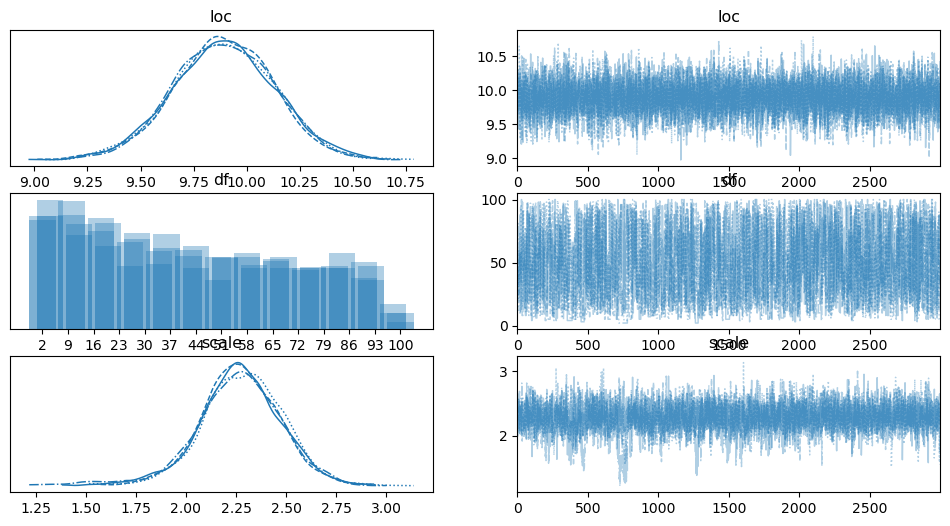

In [6]:
#HW Pt1 

import pymc as pm
import arviz as az
from scipy import stats  

# True values
mu_0, sigma_0 = 0, 10
n, loc_true, scale_true, df_true = 100, 10, 2, 15

# Generate some data
x = stats.t(df=df_true, loc=loc_true, scale=scale_true).rvs(n)

# Bayesian model PyMC
with pm.Model() as model:

    loc = pm.Normal('loc', mu=mu_0, sigma=sigma_0)
    scale = pm.HalfNormal('scale', sigma=5)
    df = pm.DiscreteUniform('df', lower=1, upper=100)

    x_obs = pm.StudentT('x_obs', mu=loc, lam=1/scale**2, nu=df, observed=x)

    trace = pm.sample(draws=3000, tune=2000, target_accept=0.95)


az.plot_trace(trace)
az.summary(trace, round_to=2)

df_summary = az.summary(trace, var_names=['df'], round_to=2)
df_ess = df_summary['ess_bulk']  # Effective sample size for the df parameter
print(f"Effective sample size for df parameter: {df_ess}")


In [11]:
# Pt2

import numpy as np
J = 8
y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])

with pm.Model() as Centered_eight:

    mu = pm.Normal("mu", mu=0, sigma=5)
    tau = pm.HalfCauchy("tau", beta=5)

    theta = pm.Normal("theta", mu=mu, sigma=tau, shape=J) # theta is length J=8

    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)


SEED = [123, 1234] 
with Centered_eight:
    fit_C = pm.sample(5000, chains=2, tune=1000, random_seed=SEED,
                      return_inferencedata=True, idata_kwargs={"log_likelihood": True})

with pm.Model() as NonCentered_eight:

    mu = pm.Normal("mu", mu=0, sigma=5)
    tau = pm.HalfCauchy("tau", beta=5)
    theta_tilde = pm.Normal("theta_t", mu=0, sigma=1, shape=J)

    theta = pm.Deterministic("theta", mu + tau * theta_tilde)
    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)

with NonCentered_eight:
    fit_NC = pm.sample(5000, chains=2, tune=1000, random_seed=SEED,
                       return_inferencedata=True, idata_kwargs={"log_likelihood": True})


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [mu, tau, theta]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 10 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [mu, tau, theta_t]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 6 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


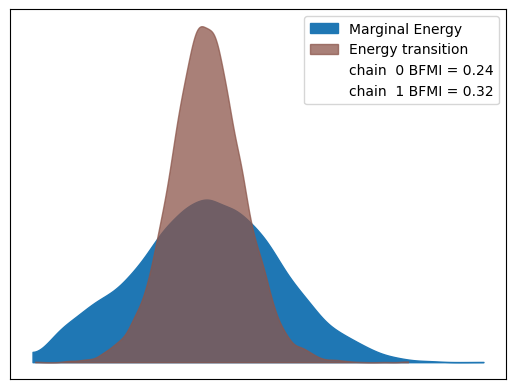

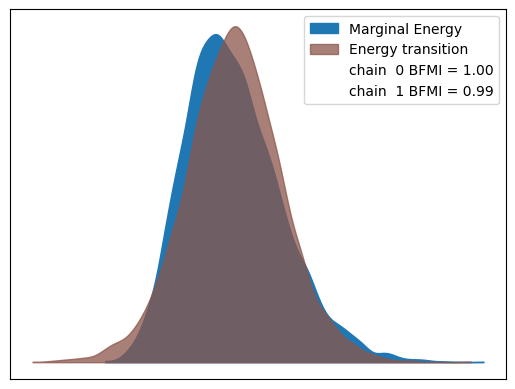

In [10]:
import arviz as az
az.plot_energy(fit_C);
az.plot_energy(fit_NC);

In the "Centered" model (Top Plot), the low Bayesian Fraction of Missing Information (BFMI) values (0.31 and 0.24) suggest a mismatch between the energy distribution of transitions and the marginal energy distribution. This discrepancy implies potential problems with sampling efficiency and hints that the "centered" parameterization could be impeding the Hamiltonian Monte Carlo (HMC) algorithm's ability to adequately explore the posterior distribution.

In the "Uncentered" model (Bottom Plot), the BFMI values approach 1 (1.05 and 0.98), suggesting a closer alignment between the energy transition and the marginal energy distribution. This indicates that the "uncentered" model facilitates a more efficient exploration of the posterior distribution by the HMC sampler. It aligns with the anticipated benefit of "uncentering," which is to mitigate challenges associated with the curvature of the energy function.

Comparative Analysis: The diagnostic findings suggest that "uncentered" parameterizations enhance the effectiveness of the HMC algorithm by mitigating potential issues in the posterior distribution, such as high curvature or "funnel" shapes, which may impede sampling efficiency. This conclusion is supported by the higher BFMI values and the improved alignment between the energy transition and marginal energy distributions observed in the "uncentered" model compared to the "centered" model.